In [109]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [110]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [111]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [112]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [113]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")
#print(X.groupby(['Target']).count())
X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

L=[]
L.append((X['Target']==0.0).sum())
L.append((X['Target']==1.0).sum())
L.append((X['Target']==2.0).sum())

print("Negative Examples : ",(X['Target']==0.0).sum())
print("Positive Examples : ",(X['Target']==1.0).sum())
print("Neutral Examples : ",(X['Target']==2.0).sum())

maximum=max(L)

Weights=[]

for i in L:
  Weights.append(maximum/i)
  
class_weights = torch.FloatTensor(Weights).to(device)
print("\n Weights = ",class_weights)


Number of Examples :  28680 

Number of Examples after removing duplicates:  28478 

Number of words before cleaning :  1086021
Number of words after cleaning :  730700

******************

Negative Examples :  3262
Positive Examples :  10112
Neutral Examples :  15104

 Weights =  tensor([4.6303, 1.4937, 1.0000], device='cuda:0')


In [114]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])


0        vianet group inc announc unaudit second quarte...
1        krato present canaccord virtual growth confer ...
2        rewalk robot report second quarter financi res...
3        pyxi tanker announc date releas second quarter...
4        bionano genom report second quarter financi re...
                               ...                        
28473    latest market buzz market go crazi spac reader...
28474    hubspot surg august digit market softwar compa...
28475    dividend increas expect septemb august anoth e...
28476    jcom final deadlin rosen trust top rank law fi...
28477    virgin galact plan next test spaceflight oct n...
Name: Article, Length: 28478, dtype: object


In [115]:
X.to_csv (r'General.csv', index = False, header=True)

In [116]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

batch=1024
#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
Train_Data=data.TabularDataset(path = 'General.csv',format = 'csv',fields = fields,skip_header = True)

X_train, X_test = Train_Data.split(split_ratio=0.75, random_state = random.seed(1234))
X_train, X_val = X_train.split(split_ratio=0.8, random_state = random.seed(1234))

TEXT.build_vocab(X_train, min_freq=2)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  



Size of TEXT vocabulary: 14642
Size of LABEL vocabulary: 3
[('stock', 6923), ('earn', 5976), ('inc', 5200), ('compani', 4757), ('announc', 4588), ('result', 4075), ('report', 3374), ('busi', 2891), ('new', 2830), ('investor', 2795)]


In [117]:
def find_accuracy(preds, y):
   
    temp = torch.log_softmax(preds, dim = 1)
    _, y_pred = torch.max(temp, dim = 1) 
    valid = (y_pred == y).float() 
    accur = valid.sum() / len(valid)
    return accur,y_pred,y

def Loss_Optimizer (model,valueLR):
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [118]:
def train(model,data,lr,optimizer,criterion):
        
    #optimizer,criterion=Loss_Optimizer (model,lr)
    #criterion = criterion.to(device)
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(0)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [119]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(0)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [120]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    #y_pred_list=MultiLabelBinarizer().fit_transform(yp)
   

    #y_true_list=MultiLabelBinarizer().fit_transform(yt)
   
   
    """idx2class=[0.0,1.0,2.0]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(yt, yp)).rename(columns=idx2class, index=idx2class)
    sns.heatmap(confusion_matrix_df, annot=True)"""
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1, 2])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix, with normalization')
    

In [121]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

In [122]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [123]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        return self.fc(hidden)

In [124]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [125]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 3
dropout = 0.4

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(14642, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
myGRU(
  (embedding): Embedding(14642, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


Epoch :  5  Train Loss :  0.33782517597736683   Train Acc :  0.748891690198113   Valid Loss :  0.3058388790115714  Val Acc :  0.7891335248947143
Epoch :  10  Train Loss :  0.19455188378582106   Train Acc :  0.8683722369811114   Valid Loss :  0.33025085739791393  Val Acc :  0.8272549748420716
Epoch :  15  Train Loss :  0.1067924794384881   Train Acc :  0.9327415683690239   Valid Loss :  0.4833761274814606  Val Acc :  0.8455788373947144
Epoch :  20  Train Loss :  0.06532741064096198   Train Acc :  0.9596210157170015   Valid Loss :  0.5920654252171517  Val Acc :  0.8449573874473572
Epoch :  25  Train Loss :  0.042824493515688705   Train Acc :  0.9731205561581779   Valid Loss :  0.7140214901417494  Val Acc :  0.8473011374473571
Epoch :  30  Train Loss :  0.029643862713676167   Train Acc :  0.9807870703585008   Valid Loss :  0.72147999368608  Val Acc :  0.8446022748947144

Time needed for Training :  1.7210334618886312

Loss in Testset :  0.8129154656614576   Accuracy in Testset :  0.828326

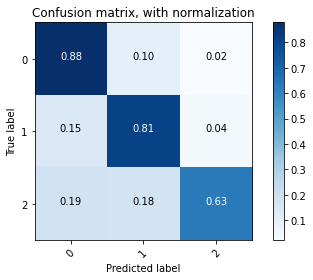

In [126]:
process_test(new_model2,30,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","best_LSTM_1_model.pt")

Epoch :  5  Train Loss :  0.3216313729610513   Train Acc :  0.7732841512736153   Valid Loss :  0.3069628641009331  Val Acc :  0.8095170497894287
Epoch :  10  Train Loss :  0.1997761564219699   Train Acc :  0.869260262040531   Valid Loss :  0.3268907189369202  Val Acc :  0.8356534123420716
Epoch :  15  Train Loss :  0.13373581322786562   Train Acc :  0.9134975426337298   Valid Loss :  0.487749257683754  Val Acc :  0.8450284123420715
Epoch :  20  Train Loss :  0.08060302486752763   Train Acc :  0.947990803157582   Valid Loss :  0.5304730301722884  Val Acc :  0.8494140625
Epoch :  25  Train Loss :  0.05725916541482815   Train Acc :  0.9644152872702655   Valid Loss :  0.5863656122237444  Val Acc :  0.8434303998947144
Epoch :  30  Train Loss :  0.04031767151044572   Train Acc :  0.974697915946736   Valid Loss :  0.7221472756005823  Val Acc :  0.8519886374473572

Time needed for Training :  1.4407414197921753

Loss in Testset :  0.8034721847091403   Accuracy in Testset :  0.8293096763747079 

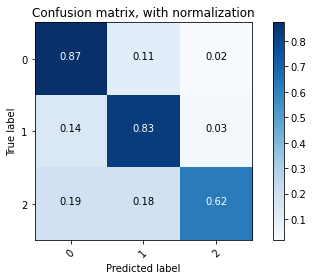

In [127]:
process_test(new_model3,30,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","best_gru_1_model.pt")